# Convolutional Neural Network
**Sekilas tentang CNN**
Convolutional Neural Network (CNN) adalah salah satu jenis neural network yang biasa digunakan pada data image. CNN bisa digunakan untuk mendeteksi dan mengenali object pada sebuah image. CNN adalah sebuah teknik yang terinspirasi dari cara mamalia — manusia, menghasilkan persepsi visual seperti contoh diatas. ([Sumber](https://medium.com/@16611110/apa-itu-convolutional-neural-network-836f70b193a4))

<br>
<div>
<img src="../assets/typicalcnn.png" width="400"/>
</div>

[Sumber Gambar](https://www.quora.com/What-is-a-typical-convolutional-neural-network-CNN-architecture)
<br>
Pada umumnya, layer pada CNN akan tampak seperti gambar di atas:
- Setelah input, akan dilajutkan dengan layer konvolusi yang berisi filter
- Setelah layer konvolusi, umumnya akan dilanjutkan dengan pooling layer
- Fully connected layer akan digunakan untuk menghasilkan output dan diletakkan pada bagian akhir

<br>
<div>
<img src="../assets/convfilter.png" width="400"/>
</div>

[Sumber Gambar](https://www.researchgate.net/publication/329241581_Using_deep_learning_to_predict_soil_properties_from_regional_spectral_data/figures?lo=1)

Filter akan dikonvolusikan terhadap input sehingga menghasilkan sebuah hasil yang ukurannya sama dengan besarnya filter yang digunakan

**Max Pooling**
Pooling merupakan pengurangan ukuran matriks dengan menggunakan operasi pooling. Pooling layer terdiri dari filter dengan ukuran dan stride tertentu yang berkonvolusi pada seluruh area feature map. Terdapa average pooling dan max pooling. Pada average pooling, nilai yang dihasilkan berdasarkan rata-rata, sementara pada max pooling, nilai yang dihasilkan adalah nilai maksimal. Lapisan Pooling yang dimasukkan diantara lapisan konvolusi secara berturut-turut dalam arsitektur model CNN dapat secara progresif mengurangi ukuran volume output pada Feature Map, sehingga mengurangi jumlah parameter dan perhitungan di jaringan, untuk mengendalikan Overfitting.([Sumber](https://medium.com/@mukhlishatunnada02/kegunaan-layar-pooling-pada-penerapan-deep-learning-menggunakan-convolutional-neural-network-140146078f28))

Berikut ini adalah contoh gambar operasi max-pooling :
<br>
<div>
<img src="../assets/pool_layer.png" width="400"/>
</div>


# Tahap Persiapan
**Mengimpor Library**

In [166]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

**Konfigurasi Device dan Hyperparameter**
- Apabila GPU tersedia, gunakan GPU
- Jika GPU tidak tersedia, gunakan CPU
- Jumlah epoch, batch, dan learning rate di definisikan pada bagian ini

In [167]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 4
batch_size = 4
learning_rate = 0.001

**Konfigurasi Transform**
- Pada percobaan ini, dataset CIFAR merupakan PILImage dengan rentang nilai pixel 0-1.
- Transformasi dilakukan untuk tipe data menjadi tensor
- Normalisasi dilakukan untuk mengubah nilai pixel menjadi 0-1

In [168]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

**Mengimpor Dataset**
- Dataset tersedia melalui fungsi ```torchvision.datasets.CIFAR10``` dengan beberapa penjelasan argumen sebagai berikut
    - ```root```: direktori dataset
    - ```train```: boolean, jika True, maka dataset akan dijadikan training set
    - ```transform```: transformasi yang dilakukan pada dataset
    - ```download```: boolean, jika True, maka dataset akan diunduh dari internet
- Dataset CIFAR10 ini merupakan dataset yang berisi 10 kategori dengan data training dan testing
- ```trainloader``` digunakan untuk memuat data training pada variabel ```trainset```
- ```testloader``` digunakan untuk memuat data testing pada variabel ```testset```
- argumen ```batch_size``` digunakan untuk mengatur jumlah data yang dibaca per batch
- argumen ```shuffle``` digunakan untuk mengatur apakah data akan diacak atau tidak
- argumen ```num_workers``` digunakan untuk mengatur jumlah thread yang digunakan untuk membaca data
    - Perlu diperhatikan bahwa jupyter notebook tidak mendukung multi-threading, jadi jika menggunakan multi-threading, maka harus menggunakan ```torch.multiprocessing.Pool```

In [169]:
trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,

                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


**Menginisiasi Kelas**

In [170]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [171]:
test_images, test_labels = next(iter(trainloader))

# Tahap Mendesain Model
Model yang akan digunakan adalah CNN dengan struktur seperti gambar berikut:

<br>
<div>
<img src="../assets/cnnmodels.jpeg" width="700"/>
</div>

([Sumber Gambar: mathworks.com](https://www.mathworks.com/discovery/convolutional-neural-network-matlab.html))

- Arsitektur ini memiliki dua komponen utama yaitu feature learning dan classifier
- Feature learning akan mempelajari fitur gambar dan menghasilkan output yang dapat digunakan untuk classifier
- Classifier yang nantinya akan menentukan gambar input masuk ke kelas yang mana

**Komponen Layer**
- Layer 1: Convolutional Layer 2 Dimensi dengan ukuran input 3 (RGB channel), ukuran output adalah 6, dan ukuran kernel adalah 5
- Layer 2: Max Pooling Layer 2 Dimensi dengan ukuran kernel 2 dan stride 2
- Layer 3: Convolutional Layer 2 Dimensi dengan ukuran channel 6, ukuran output adalah 16, dan ukuran kernel adalah 5. Ukuran input adalah output dari layer 1
- Layer 4: Max Pooling Layer 2 Dimensi dengan ukuran kernel 2 dan stride 2 (sama seperti layer 2)
- Layer 5: Image diflatten dan dimasukkan ke Fully Connected Layer dengan ukuran input 16 * 5 * 5, ukuran output adalah 120
- Layer 6: Fully connected layer dengan ukuran input 120, ukuran output adalah 84
- Layer 7: Fully connected layer dengan ukuran input 84, ukuran output adalah 10 (jumlah kelas)

**Perubahan shape image**
- Pada awalnya, gambar input adalah 3 dimensi (RGB) dengan ukuran 32x32 piksel
- Setelah melewati layer 1, gambar akan berubah menjadi 6 dimensi (RGB) dengan ukuran 28x28 piksel. Mengapa menjadi 28 piksel?
- Formula Conv Layer: $$\frac{(W - F + 2*P)}{S} + 1$$
- Width (W) awal adalah 32, dikurang dengan ukuran kernel 5 (F), ditambah 0 (tanpa padding), dan dibagi dengan stride 1 (S) dan ditambah 1
- $$\frac{(32 - 5 + 2*0)}{1} + 1 = 28$$
- Setelah melewati layer 2, gambar akan berubah menjadi 16 dimensi (RGB) dengan ukuran 14x14 piksel. Mengapa menjadi 14 piksel?
- Karena layer setelahnya adalah pooling layer dengan ukuran 2x2 dan stride 2 sehingga ukuran gambar dikurangi menjadi setengahnya
- Setelah melewati layer 3, gambar akan berubah menjadi 16 channel dengan ukuran 10x10 piksel.
- Dan setelah melewati layer ke 4, gambar akan memiliki ukuran 16 channel dengan ukuran 5x5 piksel. Karena layer setelahnya adalah pooling layer dengan ukuran 2x2 dan stride 2 sehingga ukuran gambar dikurangi menjadi setengahnya


In [172]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ConvNet().to(device)

**Mendefinisikan fungsi loss dan optimizer**

In [173]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

**Ilustrasi proses convolution layer**

***Proses ini tidak dibutuhkan untuk melakukan training. Hanya gambaran bagi anda untuk mengetahui proses convolution layer***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


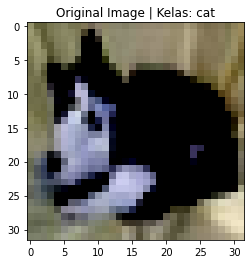

(4, 6, 28, 28)


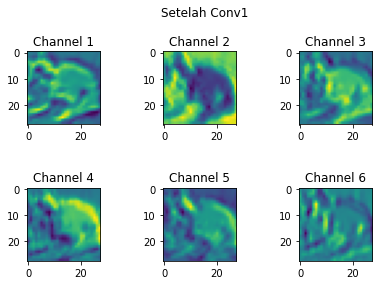

(4, 6, 14, 14)


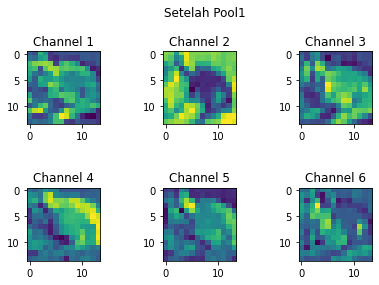

(4, 16, 10, 10)


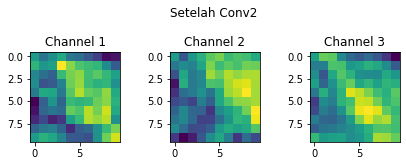

(4, 16, 5, 5)


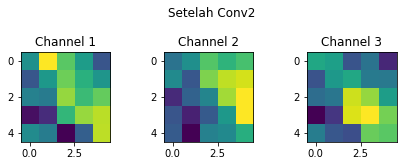

In [174]:
testconv1 = nn.Conv2d(3, 6, 5)
testpool = nn.MaxPool2d(2, 2)
testconv2 = nn.Conv2d(6, 16, 5)
testfc1 = nn.Linear(16 * 5 * 5, 120)
testfc2 = nn.Linear(120, 84)
testfc3 = nn.Linear(84, 10)

plt.imshow(test_images[0].permute(1, 2, 0))
plt.title("Original Image | Kelas: {}".format(classes[test_labels[0]]))
plt.show()

test_images = testconv1(test_images)
ungrad_test_images = test_images.cpu().detach().numpy()
print(ungrad_test_images.shape)

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout(h_pad=3)
    plt.imshow(ungrad_test_images[0, i, :, :])
    plt.title("Channel {}".format(i+1))
    plt.suptitle("Setelah Conv1")
plt.show()

test_images = testpool(test_images)
ungrad_test_images = test_images.cpu().detach().numpy()
print(ungrad_test_images.shape)

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout(h_pad=3)
    plt.imshow(ungrad_test_images[0, i, :, :])
    plt.title("Channel {}".format(i+1))
    plt.suptitle("Setelah Pool1")
plt.show()

test_images = testconv2(test_images)
ungrad_test_images = test_images.cpu().detach().numpy()
print(ungrad_test_images.shape)

for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.tight_layout(h_pad=3)
    plt.imshow(ungrad_test_images[0, i, :, :])
    plt.title("Channel {}".format(i+1))
    plt.suptitle("Setelah Conv2")
plt.show()

test_images = testpool(test_images)
ungrad_test_images = test_images.cpu().detach().numpy()
print(ungrad_test_images.shape)

for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.tight_layout(h_pad=3)
    plt.imshow(ungrad_test_images[0, i, :, :])
    plt.title("Channel {}".format(i+1))
    plt.suptitle("Setelah Pool2")
plt.show()


# Tahap Training dan Testing
**Training Loop**

In [ ]:
n_total_steps = len(trainloader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, n_total_steps, loss.item()))

print('Training Selesai')

**Testing Loop**

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]

    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    print(f'Accuracy: {n_correct/n_samples*100:.4f}%')

    for i in range(10):
        print(f'Akurasi kelas- {classes[i]}: {n_class_correct[i]/n_class_samples[i]*100:.4f}%')